# Experiment: Compare Binary Model Disengaged Features

**Goal**: assess the impact of adding different disengaged features to binary model that primarily related to violations

Related notebooks:
* `2024_03_26_EXP_compare_binary_base_features.ipynb`


> Written by Jess Breda 

## Imports

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

from multiglm.experiments.experiment import load_experiment

from multiglm.experiments.experiment_compare_models import ExperimentCompareModels

from multiglm.features.design_matrix_generator import *
from multiglm.features.design_matrix_generator_PWM import *

from multiglm.models.binary_logistic_regression import BinaryLogisticRegression
from multiglm.models.multiclass_logistic_regression import MultiClassLogisticRegression

from multiglm.visualizations.model_visualizer import *

from multiglm.data import ANIMAL_IDS
from multiglm.experiments import STANDARD_SIGMAS


sns.set_context("talk")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Model Configs

### Compare 

In [16]:
# design matrix columns shared between all models being fit
shared_cols = {
    "session": lambda df: (copy(df.session)),
    "bias": lambda df: (add_bias_column(df)),
    "s_a": lambda df: (standardize(df.s_a)),
    "s_b": lambda df: (standardize(df.s_b)),
    "prev_avg_stim": lambda df: prev_avg_stim(df, mask_prev_violation=True),
    "prev_correct": lambda df: (prev_correct_side(df)),
    "prev_choice": lambda df: (prev_choice(df)),
    "labels": binary_choice_labels(),
}

models_config = {
    "base": {
        "model_class": BinaryLogisticRegression,
        "dmg_config": {
            **shared_cols,
        },
    },
    "prev_violation_filt": {
        "model_class": BinaryLogisticRegression,
        "dmg_config": {
            **shared_cols,
            "prev_violation_filt": lambda df: (
                filtered_prev_viol(df, get_animals_tau(df, "prev_violation"))
            ),
        },
    },
    "prev_tns": {
        "model_class": BinaryLogisticRegression,
        "dmg_config": {
            **shared_cols,
            "prev_violation_filt": lambda df: (
                filtered_prev_viol(df, get_animals_tau(df, "prev_violation"))
            ),
            "prev_tns": lambda df: (prev_trial_not_started(df)),
        },
    },
    "prev_viol_stim_intrxs": {
        "model_class": BinaryLogisticRegression,
        "dmg_config": {
            **shared_cols,
            "prev_violation_filt": lambda df: (
                filtered_prev_viol(df, get_animals_tau(df, "prev_violation"))
            ),
            "prev_tns": lambda df: (prev_trial_not_started(df)),
            "s_a_x_filt_prev_viol": lambda df: (
                stim_filt_viol_intrx(df, "s_a", get_animals_tau(df, "prev_violation"))
            ),
            "s_b_x_filt_prev_viol": lambda df: (
                stim_filt_viol_intrx(df, "s_b", get_animals_tau(df, "prev_violation"))
            ),
        },
    },
    "prev_tns_stim_intrxs": {
        "model_class": BinaryLogisticRegression,
        "dmg_config": {
            **shared_cols,
            "prev_violation_filt": lambda df: (
                filtered_prev_viol(df, get_animals_tau(df, "prev_violation"))
            ),
            "prev_tns": lambda df: (prev_trial_not_started(df)),
            "s_a_x_filt_prev_viol": lambda df: (
                stim_filt_viol_intrx(df, "s_a", get_animals_tau(df, "prev_violation"))
            ),
            "s_b_x_filt_prev_viol": lambda df: (
                stim_filt_viol_intrx(df, "s_b", get_animals_tau(df, "prev_violation"))
            ),
            "sa_x_prev_tns": lambda df: combine_two_cols(
                standardize(df.s_a), prev_trial_not_started(df), operator.mul
            ),
            "sb_x_prev_tns": lambda df: combine_two_cols(
                standardize(df.s_b), prev_trial_not_started(df), operator.mul
            ),
        },
    },
}

params = {
    "animals": ANIMAL_IDS,
    "data_type": "new_trained",
    "sigmas": STANDARD_SIGMAS,
    "random_state": 47,
    "eval_train": True,
    "null_mode": "binary",
    "model_config": models_config,
}

save_name = "2024_03_26_compare_binary_disengaged_features.pkl"

ORDER = [
    "base",
    "prev_violation_filt",
    "prev_tns",
    "prev_viol_stim_intrxs",
    "prev_tns_stim_intrxs",
]

## Run

In [ ]:
experiment = ExperimentCompareModels(params)
experiment.run()
experiment.save(save_name)

## Visualize

In [8]:
experiment = load_experiment(save_name)
mvc = ModelVisualizerCompare(experiment)

/var/folders/__/8jn6qz211155h1xb451s5zcr0000gn/T/ipykernel_1792/2431235986.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for model_name, model_df in df.groupby("model_name"):
/Users/jessbreda/anaconda3/envs/an_lrn/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/jessbreda/anaconda3/envs/an_lrn/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current beha

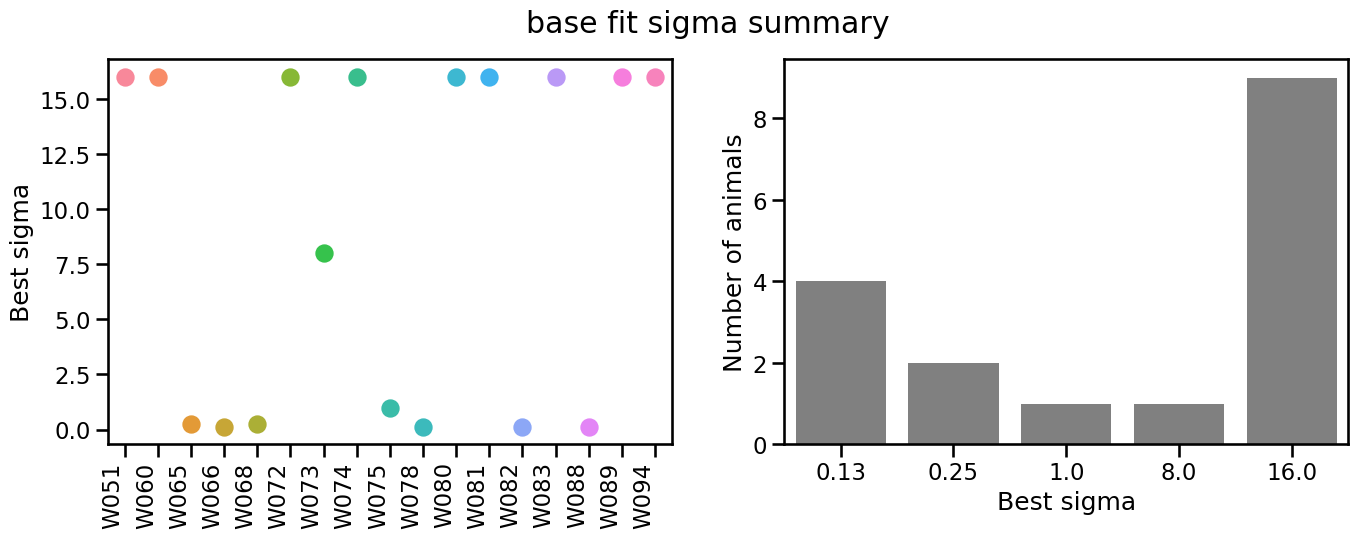

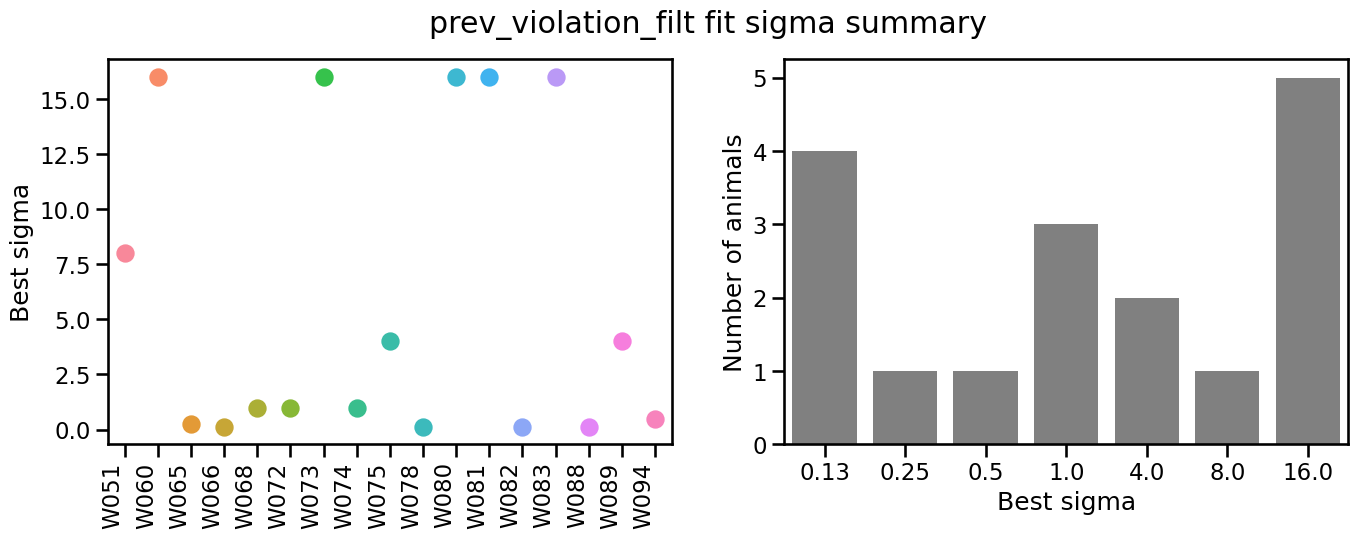

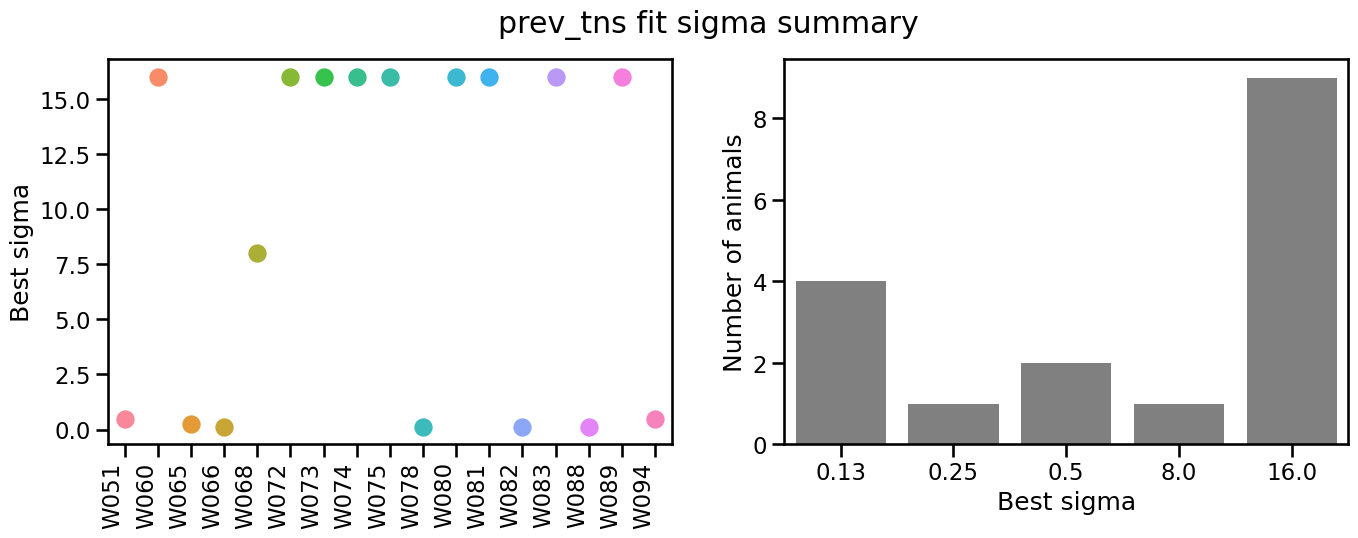

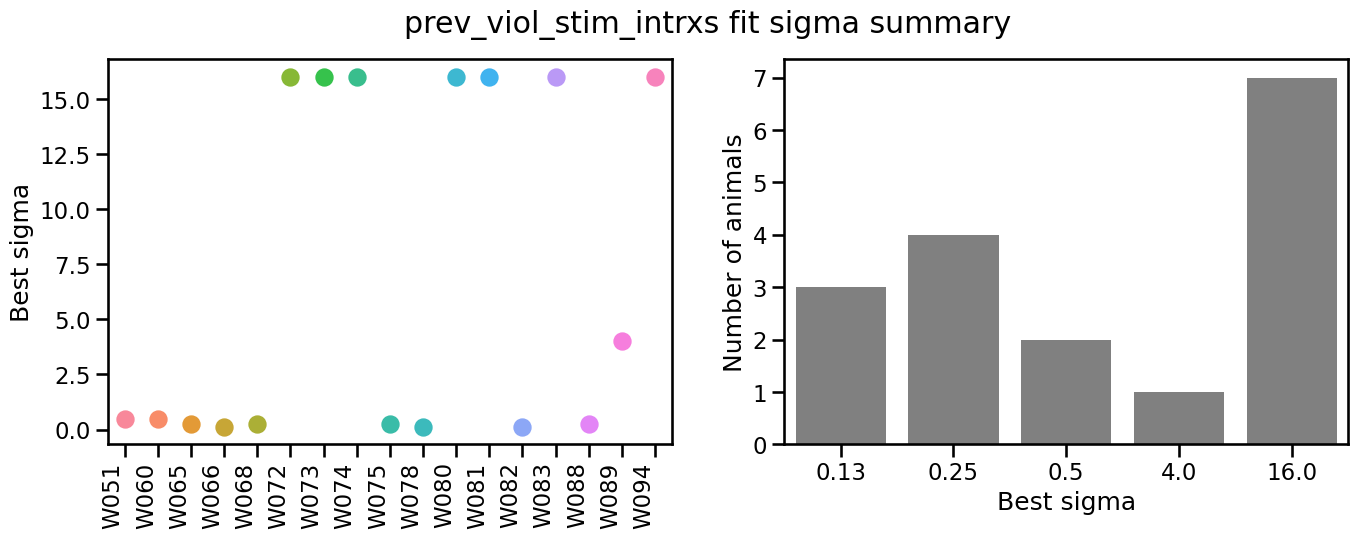

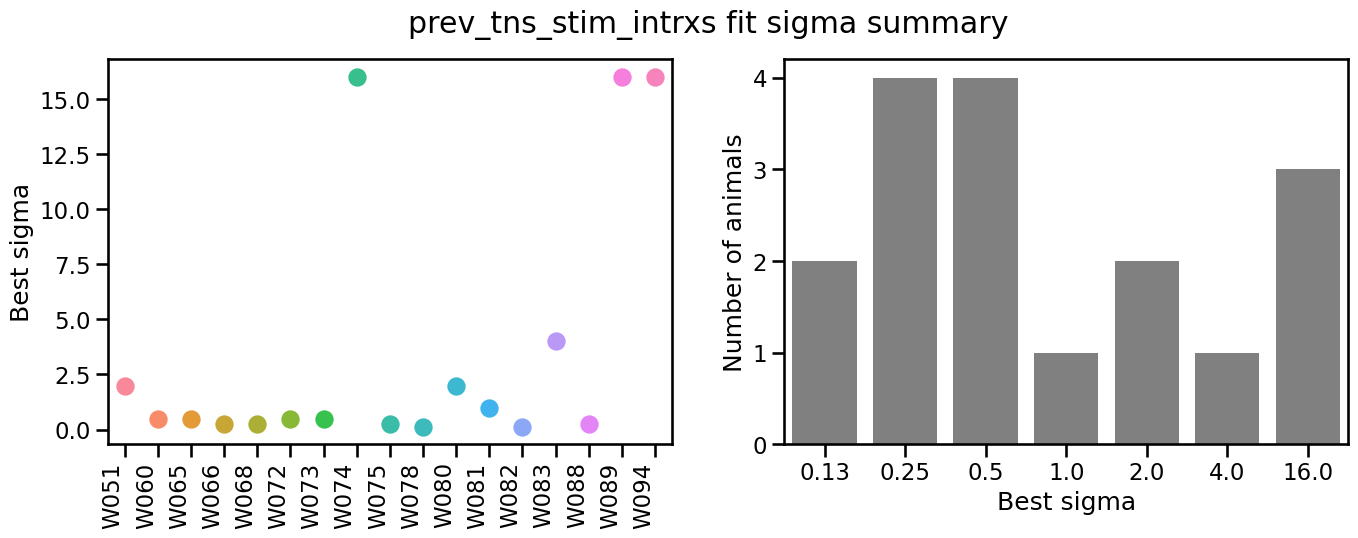

In [9]:
df = mvc.find_best_fit(group="model_name")
df["model_name"] = pd.Categorical(df["model_name"], categories=ORDER, ordered=True)
for model_name, model_df in df.groupby("model_name"):
    mvc.plot_sigma_summary(model_df, title=f"{model_name} fit sigma summary")

/var/folders/__/8jn6qz211155h1xb451s5zcr0000gn/T/ipykernel_1792/2667047998.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for ii, (model_name, model_df) in enumerate(best_fit_by_model.groupby("model_name")):


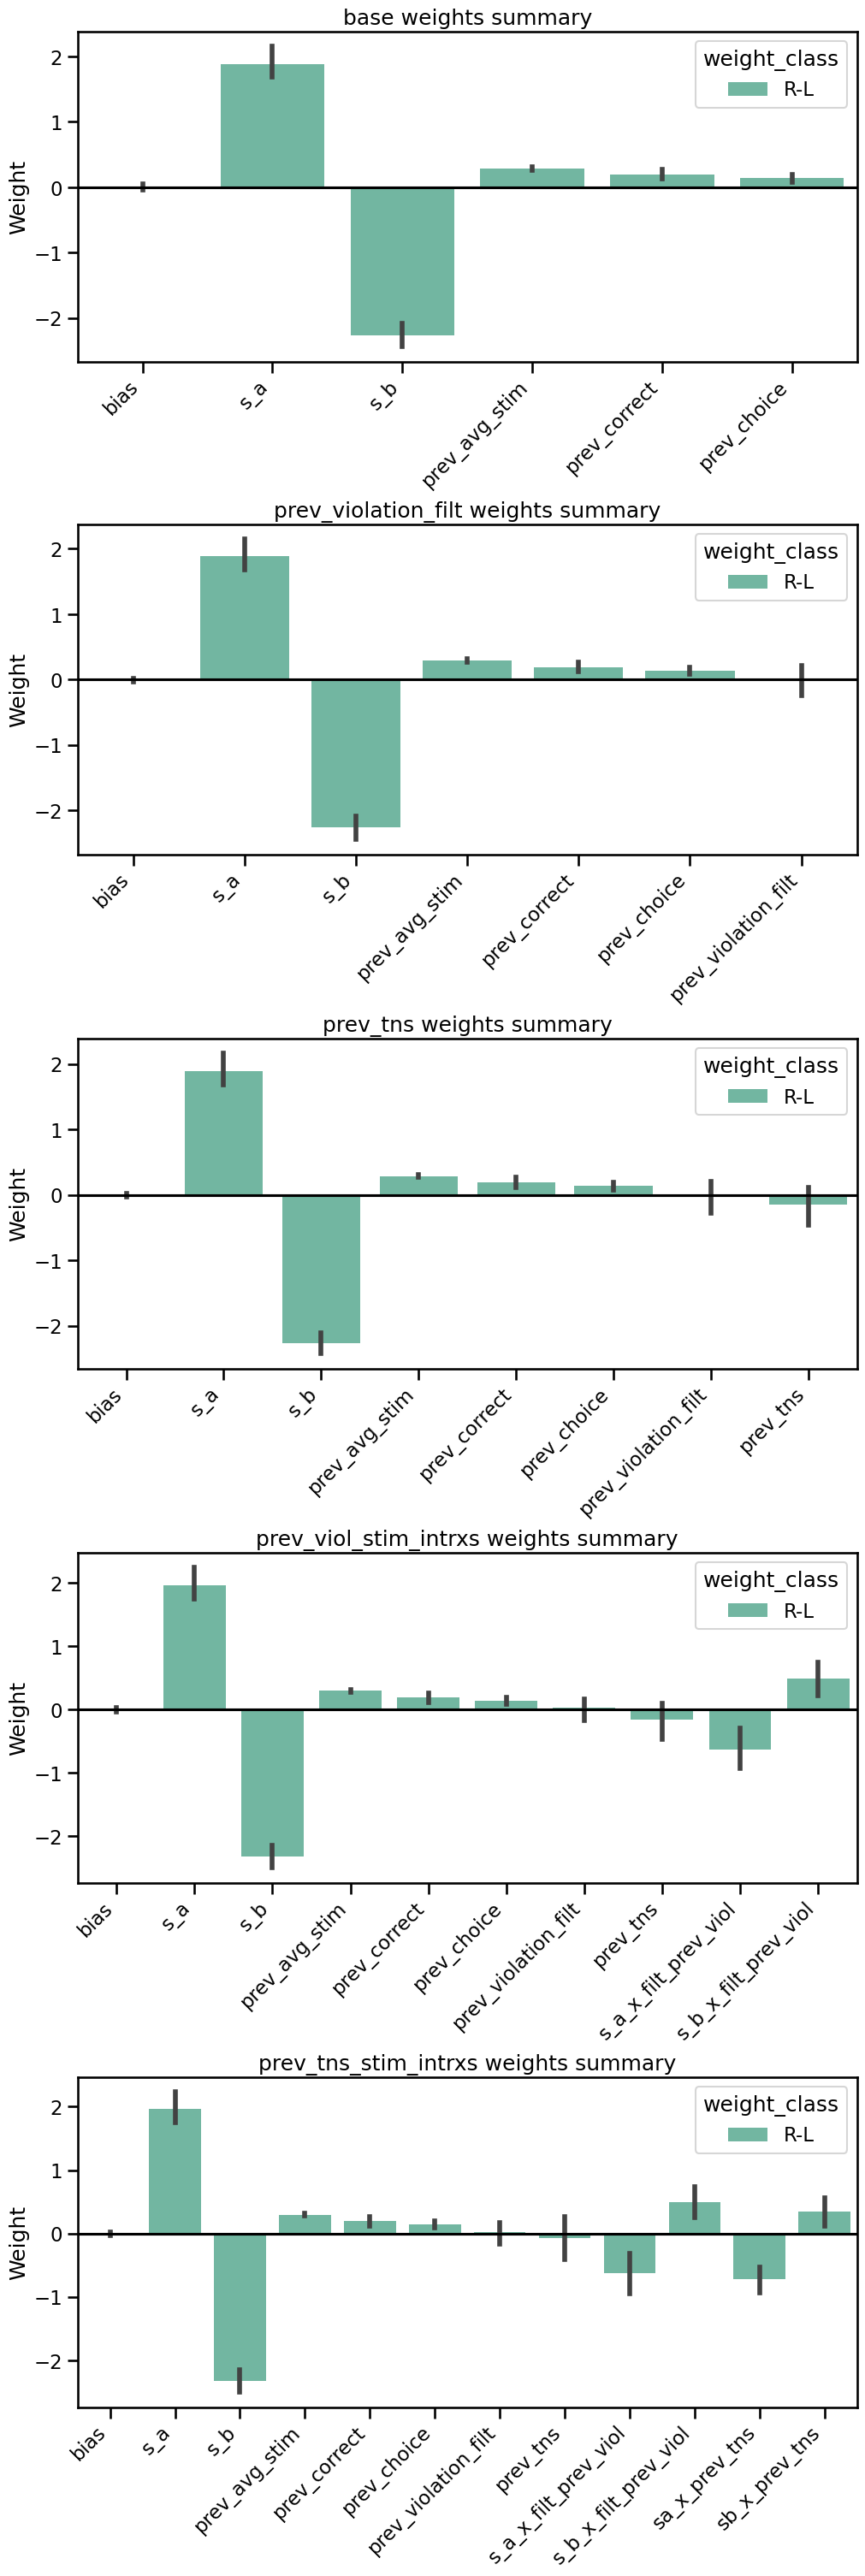

In [10]:
fig, ax = plt.subplots(
    len(ORDER), 1, figsize=(10, len(ORDER) * 6), constrained_layout=True, sharey=False
)

best_fit_by_model = mvc.find_best_fit(group=["animal_id", "model_name"])
best_fit_by_model["model_name"] = pd.Categorical(
    best_fit_by_model["model_name"], categories=ORDER, ordered=True
)

for ii, (model_name, model_df) in enumerate(best_fit_by_model.groupby("model_name")):
    unpacked = mvc.unpack_features_and_weights(model_df)

    mvc.plot_weights_summary(
        df=unpacked,
        ax=ax[ii],
        palette="Set2",
        title=f"{model_name} weights summary",
    )

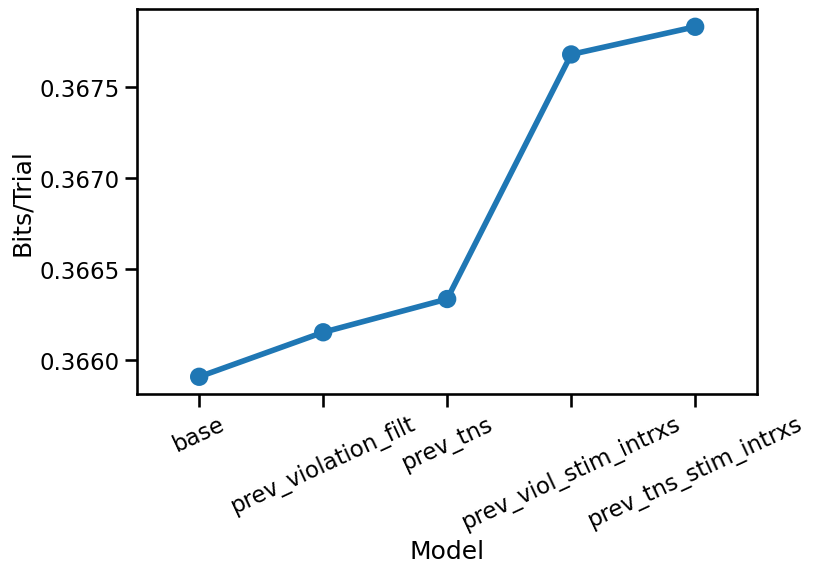

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
mvc.plot_model_comparison(
    hue=None,
    ax=ax,
    order=ORDER,
    errorbar=None,
)

/Users/jessbreda/anaconda3/envs/an_lrn/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/jessbreda/anaconda3/envs/an_lrn/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


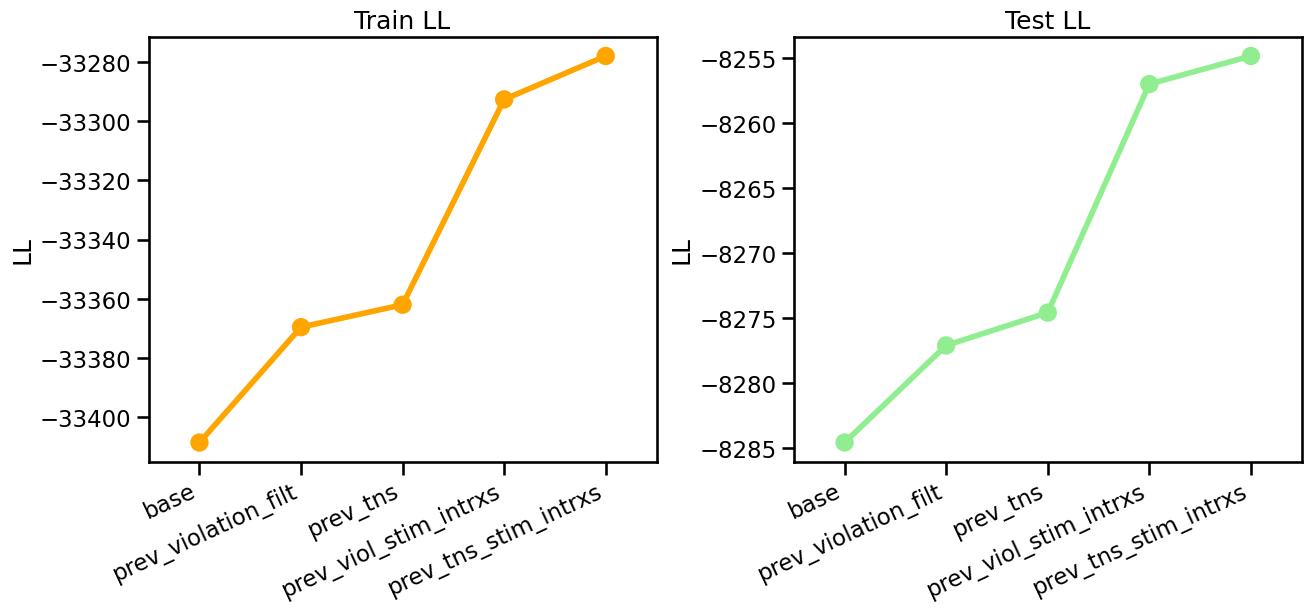

In [12]:
mvc.plot_train_and_test_ll(
    order=ORDER,
    errorbar=None,
)

<Axes: title={'center': 'Model Improvement- mu: 7.46 std: 29.16 \n base -> prev_violation_filt'}, xlabel='animal_id', ylabel='Delta test LL (new - base)'>

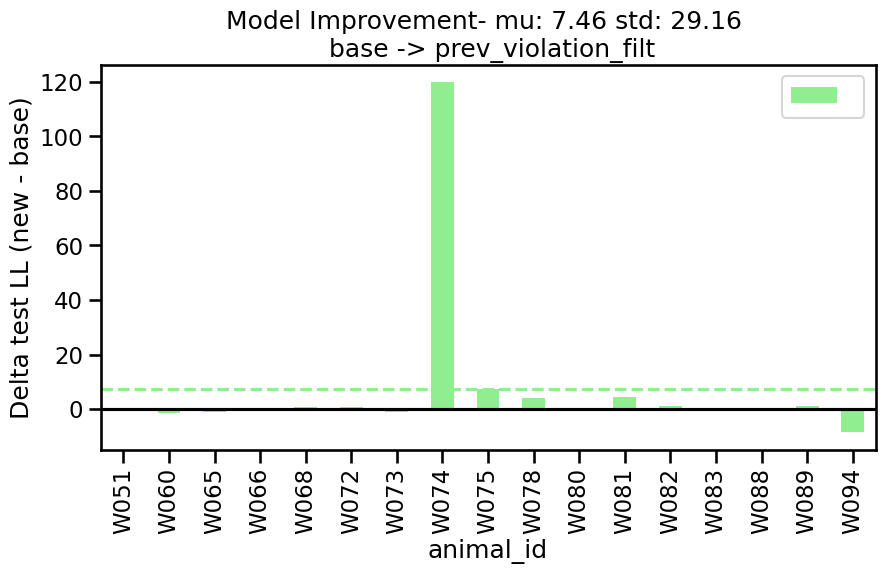

In [13]:
mvc.plot_ll_delta_by_animal(
    base_model_name=ORDER[0],
    new_model_name=ORDER[1],
    type="test",
)

<Axes: title={'center': 'Model Improvement- mu: 7.46 std: 29.16 \n base -> prev_violation_filt'}, xlabel='animal_id', ylabel='Delta test LL (new - base)'>

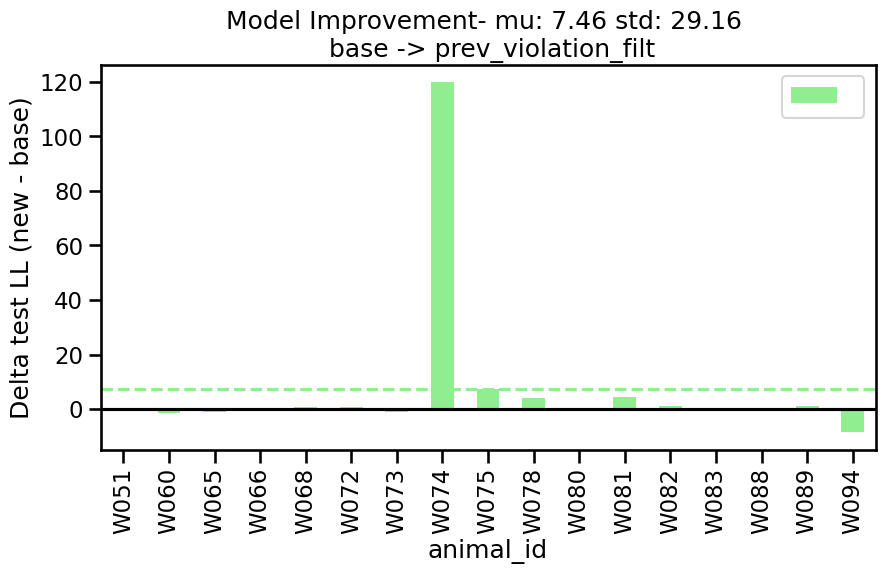

In [14]:
mvc.plot_ll_delta_by_animal(
    base_model_name=ORDER[0],
    new_model_name=ORDER[-4],
    type="test",
)

<Axes: title={'center': 'Model Improvement- mu: 9.98 std: 32.14 \n base -> prev_tns'}, xlabel='animal_id', ylabel='Delta test LL (new - base)'>

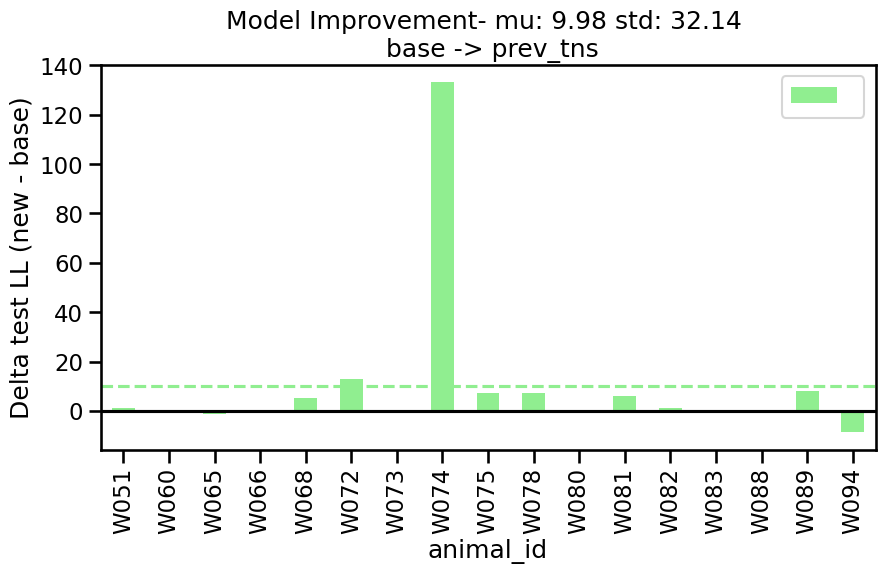

In [15]:
mvc.plot_ll_delta_by_animal(
    base_model_name=ORDER[0],
    new_model_name=ORDER[-3],
    type="test",
)